### IMPORT LIBRARY

In [59]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub 
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import pathlib
from os import getcwd
%matplotlib inline

In [60]:
print(tf.__version__)
print(tfds.__version__)

2.10.0
4.9.2


### PREPARE DATASETS

In [61]:
DATASET_DIR = pathlib.Path('D:\Kuliah\Bangkit\Capstone\capstone-growplants\model\dataset').with_suffix('')
BATCH_SIZE = 32
IMG_HEIGHT = 300
IMG_WIDTH = 300
SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

In [62]:
type_files = ('*/*.jpg', '*/*.png', '*/*.jpeg')
image_count = 0
for file in type_files:
    image_count += len(list(DATASET_DIR.glob(file)))

print(image_count)

10166


In [63]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE
)

val_ds = keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE
)

Found 10166 files belonging to 13 classes.
Using 8133 files for training.
Found 10166 files belonging to 13 classes.
Using 2033 files for validation.


In [64]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((1*val_batches) // 2)
val_ds = val_ds.skip((1*val_batches) // 2)

In [65]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 32
Number of test batches: 32


In [66]:
class_names = train_ds.class_names
print(class_names)

['Jagung_Bercak_Daun', 'Jagung_Hawar_Daun', 'Jagung_Healthy', 'Jagung_Karat_Daun', 'Kentang_Bercak_Kering', 'Kentang_Busuk_Daun', 'Kentang_Healthy', 'Kentang_Virus', 'Padi_Brown_Spot', 'Padi_Hawar_Daun', 'Padi_Healthy', 'Padi_Hispa', 'Padi_Leaf_Blast']


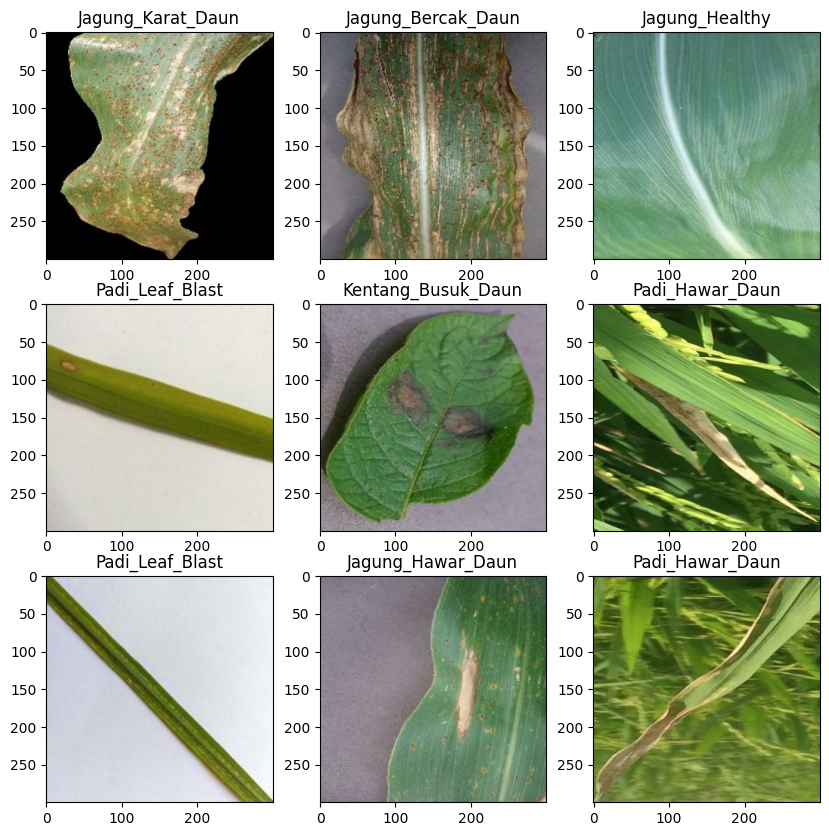

In [67]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])

In [68]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [69]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99933475


In [70]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [71]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

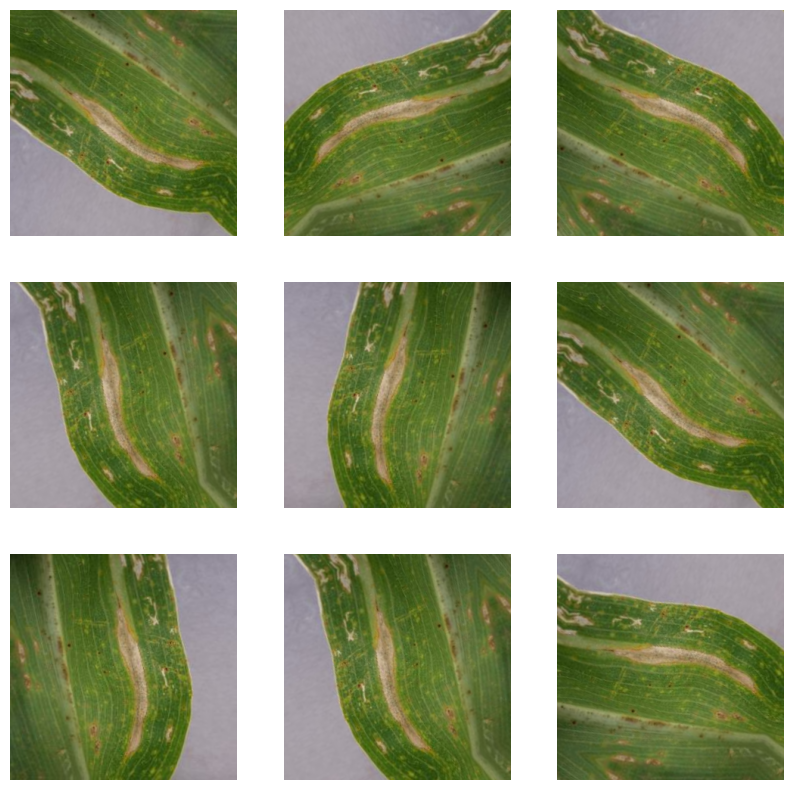

In [72]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### MODEL

In [ ]:
transfer_model = "https://tfhub.dev/agripredict/disease-classification/1"

classifier_model = transfer_model

In [52]:
num_classes = 13

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [53]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [54]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15


ValueError: in user code:

    File "c:\Users\aimar\anaconda3\envs\tf_playground\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\aimar\anaconda3\envs\tf_playground\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\aimar\anaconda3\envs\tf_playground\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\aimar\anaconda3\envs\tf_playground\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\aimar\anaconda3\envs\tf_playground\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\aimar\AppData\Local\Temp\__autograph_generated_fileanfqr80e.py", line 74, in tf__call
        ag__.if_stmt(ag__.not_(ag__.ld(self)._has_training_argument), if_body_3, else_body_3, get_state_3, set_state_3, ('result', 'training'), 1)
    File "C:\Users\aimar\AppData\Local\Temp\__autograph_generated_fileanfqr80e.py", line 72, in else_body_3
        result = ag__.converted_call(ag__.ld(smart_cond).smart_cond, (ag__.ld(training), ag__.autograph_artifact(lambda : ag__.converted_call(ag__.ld(f), (), dict(training=True), fscope)), ag__.autograph_artifact(lambda : ag__.converted_call(ag__.ld(f), (), dict(training=False), fscope))), None, fscope)
    File "C:\Users\aimar\AppData\Local\Temp\__autograph_generated_fileanfqr80e.py", line 72, in <lambda>
        result = ag__.converted_call(ag__.ld(smart_cond).smart_cond, (ag__.ld(training), ag__.autograph_artifact(lambda : ag__.converted_call(ag__.ld(f), (), dict(training=True), fscope)), ag__.autograph_artifact(lambda : ag__.converted_call(ag__.ld(f), (), dict(training=False), fscope))), None, fscope)

    ValueError: Exception encountered when calling layer "keras_layer" "                 f"(type KerasLayer).
    
    in user code:
    
        File "c:\Users\aimar\anaconda3\envs\tf_playground\lib\site-packages\tensorflow_hub\keras_layer.py", line 242, in call  *
            result = smart_cond.smart_cond(training,
    
        ValueError: Could not find matching concrete function to call loaded from the SavedModel. Got:
          Positional arguments (4 total):
            * <tf.Tensor 'inputs:0' shape=(None, 128, 128, 3) dtype=float32>
            * True
            * False
            * 0.99
          Keyword arguments: {}
        
         Expected these arguments to match one of the following 4 option(s):
        
        Option 1:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
            * True
            * False
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
        
        Option 2:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
            * True
            * True
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
        
        Option 3:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
            * False
            * True
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
        
        Option 4:
          Positional arguments (4 total):
            * TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='inputs')
            * False
            * False
            * TensorSpec(shape=(), dtype=tf.float32, name='batch_norm_momentum')
          Keyword arguments: {}
    
    
    Call arguments received by layer "keras_layer" "                 f"(type KerasLayer):
      • inputs=tf.Tensor(shape=(None, 128, 128, 3), dtype=float32)
      • training=True


In [45]:
model.evaluate(test_ds, batch_size=BATCH_SIZE)

32/32 [==============================] - 3s 63ms/step - loss: 1.3743 - accuracy: 0.6885


[1.374271035194397, 0.6884765625]